# ALZML

The goal of this project is to use publically available datasets construct a classifier to determine the features that confer Alzheimer's Disease. To do so we are combining SNP data with metadata to generate a feature rich dataset. 

First we will identify ROIs from SNP data that are known to be involved in AD. From there, adjacent features will be extracted to serve as a feature profile of the ROI. Once all ROIs have been profiled we will then run a heirarchical clustering algorithm to determine distinguishing features of these ROIs.

From these features we are hoping to construct an HMM that will be able to identify some of the underrepresented variants that may confer AD. 

Data are sourced from:
- gnomad
- IGAP
- TBI Study
- Zou eGWAS
- Mayo eGWAS
- NG00061
- NG00039

IGAP data will be used as the determinant for a ROI. A +/- 5kb region from the location of the SNP will serve as an anchor to gather local features using bedtools in order to retain positional information. 

### Only run bash block if files need to be parsed properly (shouldn't happen)

In [1]:
%%bash
#head -n 10 ng00061/WES_release3AtlasOnly_vep80_most_severe_consequence_per_gene.txt
# These have different numbers of columns of course. Need to fix this maybe? Will only use the coordinates from this
# for now, this is the primary key to link all the other datasets.
#head -n 10 ng00061/WES_release3AtlasOnly_rolling_flat_annotation.txt
#cut -f1-5 WGS_v1_rolling_flat_annotation.txt > WGS_v1_rolling_flat_annotation.pos_only.txt

#head -n 10 ../IGAP_summary_statistics/IGAP_stage_1_2_combined.txt

# I will join all of the chromosomes into one file.
#cat /home/twaddlac/Hackthan_AD/ng00039/pvalue_only/metaanalysis/pvalueonly_METAANALYSIS1_chr*.TBL | perl -pe 's/^(\d+)-(\d+)/$1\t$2/g' > pvalue_only.tsv
#head -n 10 ../pvalue_only.tsv

#I'm not sure what the difference is between these but I am assuming we get the inverse of controls here.
# We will use the controls for a confusion matrix
#ls ../Mayo_eGWAS/
#head ../Mayo_eGWAS/Hap300_CER_All.txt

# Only going to use the coordinates of the annotation files since they have mismatching columns.
##### Only run this once #####
#cut -f1-5 ../NG00061/WGS_v1_rolling_flat_annotation.txt > ../NG00061/WGS_v1_rolling_flat_annotation.pos_only.txt

## only need to run once
#cat <(grep -m1 '^Marker' /home/twaddlac/Hackthan_AD/ng00039/pvalue_only/pvalue/pvalueonly_METAANALYSIS1_chr10.TBL) <(cat /home/twaddlac/Hackthan_AD/ng00039/pvalue_only/pvalue/*TBL | perl -pe 's/(\d+)-(\d+)/$1\t$2/g'| grep -v '^Marker') > /home/twaddlac/Hackthan_AD/ng00039/pvalue_only/pvalue/pvalue.tsv

## IGAP Data

In [3]:
import pandas as pd
igap1 = pd.read_csv('../IGAP_summary_statistics/IGAP_stage_1.txt', sep='\t')
igap12 = pd.read_csv('../IGAP_summary_statistics/IGAP_stage_1_2_combined.txt', sep='\t')
igap1.rename(columns={
    'Chromosome':'chr',
    'Position':'pos'
}, inplace=True)
igap12.rename(columns={
    'Chromosome':'chr',
    'Position':'pos'
}, inplace=True)

## NG00061

In [4]:
anno = pd.read_csv('../NG00061/WGS_v1_rolling_flat_annotation.pos_only.txt', sep='\t', header=0)

In [5]:
conseq = pd.read_csv('../NG00061/WGS_v1_vep80_most_severe_consequence_per_gene.txt', sep='\t', header=0)

## NG00039

In [5]:
pvalue = pd.read_csv('../ng00039/pvalue_only/pvalue/pvalue.tsv', sep='\t', header=0, index_col=False)
# pvalue.columns = ['chr','pos','allele1','allele2','pvalue']

FileNotFoundError: [Errno 2] File b'../ng00039/pvalue_only/pvalue/pvalue.tsv' does not exist: b'../ng00039/pvalue_only/pvalue/pvalue.tsv'

## Mayo_eGWAS

In [7]:
hapCerAd = pd.read_csv('/home/twaddlac/Hackthan_AD/Mayo_eGWAS/Hap300_CER_AD.txt', sep='\t', header=0)
hapTxAd = pd.read_csv('/home/twaddlac/Hackthan_AD/Mayo_eGWAS/Hap300_TX_AD.txt', sep='\t', header=0)
hapmapCerAd = pd.read_csv('/home/twaddlac/Hackthan_AD/Mayo_eGWAS/HapMap2_CER_AD.txt', sep='\t', header=0)
hapmapTxAd = pd.read_csv('/home/twaddlac/Hackthan_AD/Mayo_eGWAS/HapMap2_TX_AD.txt', sep='\t', header=0)

hapCerAd.rename(columns={'CHR':'chr','BP':'pos'}, inplace=True)
hapTxAd.rename(columns={'CHR':'chr','BP':'pos'}, inplace=True)
hapmapCerAd.rename(columns={'CHR':'chr','BP':'pos'}, inplace=True)
hapmapTxAd.rename(columns={'CHR':'chr','BP':'pos'}, inplace=True)

## TBI Study Expression Data
There's a lot more data for this dataset but we can import it later.

In [7]:
ge = pd.read_csv('../TBI_study/gene_expression_matrix_2016-03-03/fpkm_table_normalized.csv', sep=',', header=0)

## gnomad data

In [8]:
gnomad = pd.read_csv('../IGAP_summary_statistics/gnomad_gwas_intersect.txt', )

# CRAVAT Data
CRAVAT dumps a sqllite3 file that I've read in. The only interesting tables seem to be variants and genes.

The genes that are implicated in AD are seen below:
Chromosome 11       PICAL
Chromosome 2        BIN1
Chromosome 19      CD33
Chromosome 1        CR1
Chromosome 7       EPHA1
Chromosome 6       TREM2
Chromosome 19.     ABCA7
Chromosome 11      SORL
Chromosome 12.    ADAM10
Chromosome     2.     ADAM17
Chromosome 7    AKAP9
Chromosome 4    UNC5C
Chromosome 19    APOE

It seems like clustering mulitple datatypes can be done as described in this article:
https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3

Let's try it out!

The first step is to convert all of the categorical data to some numeric representation. I found a good post on how to do so [here](https://pbpython.com/categorical-encoding.html)

We will then also make some assumtions about the data to help reduce the number of features (columns) represented in the dataframe. Those being:
If there is `none` for the transcript ID then we will assume it is in an exon. We can therefore drop the gene.

TO DROP:
base__chrom
base__pos
base__note
base__hugo
base__all_mappings
vest__all_results
vest__hugo
vest__transcript
base__uid
denovo__PubmedId
denovo__Validation
denovo__PrimaryPhenotype
cosmic__protein_change
cosmic__transcript
cosmic__variant_count
cosmic__cosmic_id
clinvar__sig
clinvar__id
clinvar__rev_stat
clinvar__disease_refs
clinvar__disease_names
gtex__gtex_gene
gtex__gtex_tissue
uk10k_cohort__uk10k_twins_ac
uk10k_cohort__uk10k_alspac_ac
uk10k_cohort__uk10k_ac
vest__pval
vest__score
tagsampler__numsample
tagsampler__samples
tagsampler__tags
repeat__repeatname
dbsnp__snp

In [54]:
pd.options.display.max_columns = 500
pd.options.display.max_colwidth = 1000
variant.head()
# variant['base__all_mappings']

,base__uid,base__chrom,base__pos,base__ref_base,base__alt_base,base__note,base__coding,base__hugo,base__transcript,base__so,base__achange,base__all_mappings,clinvar__sig,clinvar__disease_refs,clinvar__disease_names,clinvar__rev_stat,clinvar__id,cosmic__cosmic_id,cosmic__variant_count_tissue,cosmic__variant_count,cosmic__transcript,cosmic__protein_change,dbsnp__snp,denovo__PubmedId,denovo__PrimaryPhenotype,denovo__Validation,esp6500__ea_pop_af,esp6500__aa_pop_af,gnomad__af,gnomad__af_afr,gnomad__af_amr,gnomad__af_asj,gnomad__af_eas,gnomad__af_fin,gnomad__af_nfe,gnomad__af_oth,gnomad__af_sas,gtex__gtex_gene,gtex__gtex_tissue,repeat__repeatclass,repeat__repeatfamily,repeat__repeatname,thousandgenomes__af,thousandgenomes__afr_af,thousandgenomes__amr_af,thousandgenomes__eas_af,thousandgenomes__eur_af,thousandgenomes__sas_af,thousandgenomes__chb_af,thousandgenomes__jpt_af,thousandgenomes__chs_af,thousandgenomes__cdx_af,thousandgenomes__khv_af,thousandgenomes__ceu_af,thousandgenomes__tsi_af,thousandgenomes__fin_af,thousandgenomes__gbr_af,thousandgenomes__ibs_af,thousandgenomes__yri_af,thousandgenomes__lwk_af,thousandgenomes__gwd_af,thousandgenomes__msl_af,thousandgenomes__esn_af,thousandgenomes__asw_af,thousandgenomes__acb_af,thousandgenomes__mxl_af,thousandgenomes__pur_af,thousandgenomes__clm_af,thousandgenomes__pel_af,thousandgenomes__gih_af,thousandgenomes__pjl_af,thousandgenomes__beb_af,thousandgenomes__stu_af,thousandgenomes__itu_af,uk10k_cohort__uk10k_twins_ac,uk10k_cohort__uk10k_twins_af,uk10k_cohort__uk10k_alspac_ac,uk10k_cohort__uk10k_alspac_af,uk10k_cohort__uk10k_ac,uk10k_cohort__uk10k_af,vest__transcript,vest__score,vest__pval,vest__all_results,vest__hugo,vista_enhancer__element,vista_enhancer__features,tagsampler__numsample,tagsampler__samples,tagsampler__tags
0,1,chr19,39418764,C,T,None,Y,PLEKHG2,ENST00000425673.5,STG,R372*,"{""PLEKHG2"":[[null,""R372*"",""STG"",""ENST00000409797.6"",""C1114T""],[""Q9H7P9"",""R372*"",""STG"",""ENST00000425673.5"",""C1114T""],[""E7ESZ3"",""R313*"",""STG"",""ENST00000458508.6"",""C937T""]]}",None,None,None,None,None,None,None,NaN,None,None,rs774367341,None,None,None,NaN,NaN,0.000028,NaN,NaN,0.000099,NaN,NaN,0.000044,NaN,0.000033,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000458508.6,0.441,0.29194,"ENST00000409797.6(0.401:0.3212),ENST00000425673.5(0.435:0.29606),*ENST00000458508.6(0.441:0.29194)",PLEKHG2,None,None,0,,
1,2,chr19,39418783,A,G,None,Y,PLEKHG2,ENST00000425673.5,MIS,K378R,"{""PLEKHG2"":[[null,""K378R"",""MIS"",""ENST00000409797.6"",""A1133G""],[""Q9H7P9"",""K378R"",""MIS"",""ENST00000425673.5"",""A1133G""],[""E7ESZ3"",""K319R"",""MIS"",""ENST00000458508.6"",""A956G""]]}",None,None,None,None,None,None,None,NaN,None,None,rs1429162441,None,None,None,NaN,NaN,0.000064,NaN,NaN,NaN,NaN,NaN,0.000130,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000409797.6,0.278,0.38063,"*ENST00000409797.6(0.278:0.38063),ENST00000425673.5(0.236:0.46169),ENST00000458508.6(0.257:0.41939)",PLEKHG2,None,None,0,,
2,3,chr19,39418784,G,T,None,Y,PLEKHG2,ENST00000425673.5,MIS,K378N,"{""PLEKHG2"":[[null,""K378N"",""MIS"",""ENST00000409797.6"",""G1134T""],[""Q9H7P9"",""K378N"",""MIS"",""ENST00000425673.5"",""G1134T""],[""E7ESZ3"",""K319N"",""MIS"",""ENST00000458508.6"",""G957T""]]}",None,None,None,None,None,None,None,NaN,None,None,rs773266798,None,None,None,NaN,NaN,0.000032,0.000115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000409797.6,0.564,0.14756,"*ENST00000409797.6(0.564:

In [215]:
import re
import pandas as pd
import sqlite3
conn = sqlite3.connect("../chr19_test_data/chr19_test.sqlite")
# cursor = conn.cursor()
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursor.fetchall())

variant_annotator = pd.read_sql_query("SELECT * FROM variant_annotator", conn)
variant = pd.read_sql_query("SELECT * FROM variant", conn)
variant_header  = pd.read_sql_query("SELECT * FROM variant_header", conn)
variant_reportsub = pd.read_sql_query("SELECT * FROM variant_reportsub", conn)
gene_annotator = pd.read_sql_query("SELECT * FROM gene_annotator", conn)
gene = pd.read_sql_query("SELECT * FROM gene", conn)
gene_header  = pd.read_sql_query("SELECT * FROM gene_header", conn)
gene_reportsub = pd.read_sql_query("SELECT * FROM gene_reportsub", conn)
sample = pd.read_sql_query("SELECT * FROM sample", conn)
mapping  = pd.read_sql_query("SELECT * FROM mapping", conn)
variant_filtered = pd.read_sql_query("SELECT * FROM variant_filtered", conn)
gene_filtered = pd.read_sql_query("SELECT * FROM gene_filtered", conn)
info = pd.read_sql_query("SELECT * FROM info", conn)

# Objects are basically the non-numeric datatypes which we will need to convert. 
# variant.dtypes

# variant.rownames = variant['dbsnp__snp']

# These columns seem to have little/no significance as of now and will also increase the size of the matrix.
dropCols = [
    'base__chrom',
    'base__pos',
    'base__note',
    'base__achange',
    'base__hugo',
    'base__all_mappings',
    'vest__all_results',
    'vest__hugo',
    'vest__transcript',
    'base__uid',
    'denovo__PubmedId',
    'denovo__Validation',
    'denovo__PrimaryPhenotype',
    'cosmic__protein_change',
    'cosmic__transcript',
    'cosmic__variant_count',
    'cosmic__cosmic_id',
    'clinvar__sig',
    'clinvar__id',
    'clinvar__rev_stat',
    'clinvar__disease_refs',
    'clinvar__disease_names',
    'gtex__gtex_gene',
    'gtex__gtex_tissue',
    'uk10k_cohort__uk10k_twins_ac',
    'uk10k_cohort__uk10k_alspac_ac',
    'uk10k_cohort__uk10k_ac',
    'vest__pval',
    'tagsampler__numsample',
    'tagsampler__samples',
    'tagsampler__tags',
    'repeat__repeatname',
    'vest__score',
    'dbsnp__snp',
    'cosmic__variant_count_tissue'
]

# Dropping thousand genomes columns since they're all 0
r = re.compile('^thousand*')
dropCols.extend(list(filter(r.match,variant.columns)))
variant = variant.drop(columns=dropCols, axis=1)

# We will also assume that if there are no frequnecy values in frequency columns then we will assign a 0
# Selecting all the allele frequency columns
r = re.compile(".*af.*")
afCols = list(filter(r.match,variant.columns))
for col in afCols:
    variant[col][variant[col].isnull()] = 0
    variant[col].astype('float64')
    
# To further reduce featureset we will use the length of the variant as the ref base/alt base for now.
# We can use the achange field's biochemical properties to provide further resolution in the absence
# of sequence content.
def getLen(x):
    return len(x)

# variant['base__ref_base_len'] = 0
# variant['base__alt_base_len'] = 0
variant['base__ref_base_len'] = variant['base__ref_base'].apply(getLen)
variant['base__alt_base_len'] = variant['base__alt_base'].apply(getLen)
variant['base__ref_base_len'].astype('int64')
variant['base__alt_base_len'].astype('int64')
variant = variant.drop(columns=['base__ref_base','base__alt_base'], axis=1)


# We will assume that if there is a transcript ID then then variant will be in an exon so we will set this as a binary
# flag.
variant['base__transcript'][variant['base__transcript'].isnull()] = 0
variant['base__transcript'][variant['base__transcript'].notnull()] = 1

#  selecting only the 'object' dtypes (categorigal variables). 
cat_var = variant.select_dtypes(include=['object']).copy()
con_var = variant.select_dtypes(exclude=['object']).copy()

# This is label encoding 
# which seems like it might not be great for clustering, 
# though not sure for hierarchical clustering...
# for col in test_var.columns:
#     test_var[col] = test_var[col].astype('category')
#     test_var[col+'_cat'] = test_var[col].cat.codes

# This is how to do one-hot encoding. Very similar to the melt fxn in R's reshape2 package
test = pd.get_dummies(cat_var)

# This is concatenating the categorical and continuous dfs into one giant matrix
var = pd.concat([test, con_var], sort=False, axis=1)
var.head()


/usr/local/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,base__coding_Y,base__transcript_1,base__so_2KD,base__so_2KU,base__so_CSS,base__so_FSD,base__so_IND,base__so_INT,base__so_MIS,base__so_SPL,base__so_STG,base__so_STL,base__so_SYN,base__so_UNK,base__so_UT3,base__so_UT5,repeat__repeatclass_LINE,"repeat__repeatclass_LINE,SINE",repeat__repeatclass_LTR,repeat__repeatclass_Low_complexity,repeat__repeatclass_SINE,"repeat__repeatclass_SINE,LINE","repeat__repeatclass_SINE,SINE",repeat__repeatclass_Satellite,repeat__repeatclass_Simple_repeat,"repeat__repeatclass_Simple_repeat,SINE",repeat__repeatfamily_Alu,"repeat__repeatfamily_Alu,Alu",repeat__repeatfamily_CR1,repeat__repeatfamily_ERV1,repeat__repeatfamily_ERVK,repeat__repeatfamily_ERVL,repeat__repeatfamily_ERVL-MaLR,repeat__repeatfamily_L1,"repeat__repeatfamily_L1,Alu",repeat__repeatfamily_L2,repeat__repeatfamily_Low_complexity,repeat__repeatfamily_MIR,"repeat__repeatfamily_MIR,L2",repeat__repeatfamily_RTE-BovB,repeat__repeatfamily_Satellite,repeat__repeatfamily_Simple_repeat,"repeat__repeatfamily_Simple_repeat,Alu",repeat__repeatfamily_tRNA-RTE,esp6500__ea_pop_af,esp6500__aa_pop_af,gnomad__af,gnomad__af_afr,gnomad__af_amr,gnomad__af_asj,gnomad__af_eas,gnomad__af_fin,gnomad__af_nfe,gnomad__af_oth,gnomad__af_sas,uk10k_cohort__uk10k_twins_af,uk10k_cohort__uk10k_alspac_af,uk10k_cohort__uk10k_af,base__ref_base_len,base__alt_base_len
0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000028,0.000000,0.000000,0.000099,0.000000,0.0,0.000044,0.0,0.000033,0.0,0.0,0.0,1,1
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000064,0.000000,0.000000,0.000000,0.000000,0.0,0.000130,0.0,0.000000,0.0,0.0,0.0,1,1
2,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000032,0.000115,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1,1
3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000014,0.000120,0.000028,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1,1
4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000032,0.000000,0.000000,0.000000,0.000642,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1,1


In [216]:
print(variant.shape)
print(con_var.shape)
print(cat_var.shape)
print(test.shape)
print(var.shape)

(10096, 23)
(10096, 16)
(10096, 7)
(10096, 44)
(10096, 60)


In [183]:
# variant.select_dtypes(include=['object'])
# variant.dtypes
variant['base__alt_base_len'].value_counts().sort_values(ascending=False)
# variant[afCols].isnull()

1    9887
2      85
3      36
4      36
9      28
5      10
6       9
7       4
8       1
Name: base__alt_base_len, dtype: int64

# Clustering CRAVAT Data

Now that the data have been rendered in a matrix with the categorical and continuous data represented appropriately we can now cluster these data to see what are the defining features for these variants.


In [246]:
%matplotlib notebook
from sklearn import cluster 
import matplotlib.pyplot as plt

cluster = cluster.FeatureAgglomeration(n_clusters=30)
cluster.fit(var)
print(cluster.labels_)
# var_reduced = agglo.transform(var)
# var_reduced.shape

[17 23 27 19  0  0  0 21 18  0 28  0 25  0 20  9  8  0 22  5 10  0  0 12
  6  0 15  0  0 26 16 24  4 29  0  7  5 13  0  0 12  6  0 14  2  2  1  1
  1  1  1  1  1  1  2  0  0  0 11  3]


<IPython.core.display.Javascript object>


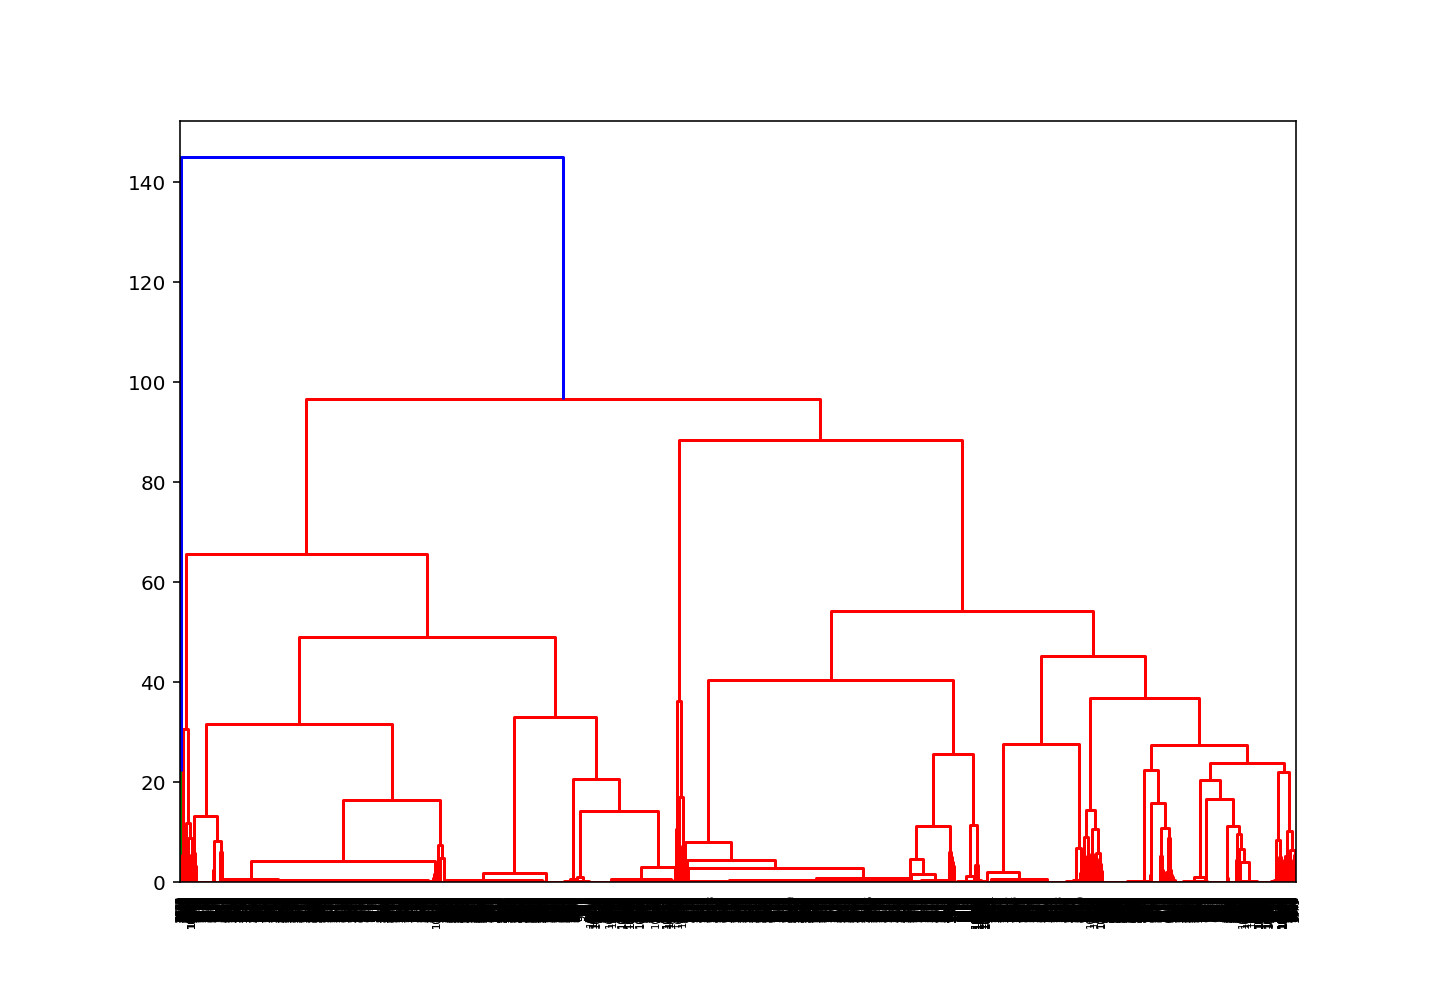

In [248]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
# plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(var, method='ward'))  

# Joining Datasets
The file linking everything together will be the annotation data from NG00061 as it should hold the complete set of SNPs. I will use coordinates from this table to join.

In [8]:
headers = ['chr','pos']
temp = anno.merge(pvalue, how='left', left_on=headers, right_on=headers)

In [9]:
temp

,chr,pos,alt_allele,seq_meta_var_id,epacts_var_id,Allele1,Allele2,P-value
0,10,60494,G,"10:60494A,G",10:60494_A/G,a,g,0.32420
1,10,60523,G,"10:60523T,G",10:60523_T/G,t,g,0.37210
2,10,61331,G,"10:61331A,G",10:61331_A/G,a,g,0.75160
3,10,61334,A,"10:61334G,A",10:61334_G/A,NaN,NaN,NaN
4,10,61646,G,"10:61646A,G",10:61646_A/G,NaN,NaN,NaN
5,10,61654,A,"10:61654G,A",10:61654_G/A,NaN,NaN,NaN
6,10,61766,A,"10:61766G,A",10:61766_G/A,NaN,NaN,NaN
7,10,62450,A,"10:62450G,A",10:62450_G/A,NaN,NaN,NaN
8,10,66295,T,"10:66295C,T",10:66295_C/T,NaN,NaN,NaN
9,10,66326,G,"10:66326A,G",10:66326_A/G,a,g,0.58810


In [ ]:
# Breaks kernel. Don't run in notebook.
from functools import reduce
dataframes = [
    anno,
    pvalue,
    conseq,
    igap1,
    igap12,
    hapCerAd,
    hapTxAd,
    hapmapCerAd,
    hapmapTxAd
]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['chr','pos'],
                                                how='outer'), dataframes).fillna('void')